In [ ]:
import numpy as np
from numpy.typing import NDArray
from numpy import float_
import matplotlib.pyplot as plt
from time import time


from typing import Union
from numpy.typing import NDArray
from numpy import float_

from tqdm import tqdm

In [187]:
rng = np.random.default_rng(seed=0xBEDABEDA)

# Recursion

In [211]:
def simulate_brownian_motion_from_increments(
    size: int,
    t_grid: Union[float, NDArray[float_]],
    dim: int = 1,
    rng: np.random.Generator = None
) -> Union[float, NDArray[float_]]:
    """
    Simulates the trajectory of the standard d-dimensional Brownian motion with the increments method.

    Args:
        t_grid: time grid to simulate the price on.
        size: number of simulated trajectories.
        dim: dimensionality of the Brownian motion.
        rng: `np.random.Generator` used for simulation.

    Returns:
        np.ndarray of shape (size, len(t_grid)) with simulated trajectories if model dimension is 1.
        np.ndarray of shape (size, dim, len(t_grid)) with simulated trajectories if model dimension greater than 1.
    """
    if rng is None:
        rng = np.random.default_rng(seed=DEFAULT_SEED)
    dt = np.diff(np.concatenate([np.zeros(1), t_grid]))
    if np.any(dt < 0):
        raise ValueError("Time grid should be increasing.")
    dW = rng.normal(size=(size, dim, len(t_grid)))
    return np.cumsum(np.sqrt(dt) * dW, axis=2)

In [ ]:
def get_next_t_path_idx(t_grid):
    if isinstance(t_grid, np.int64):
        return None
    if t_grid.shape[0] <= 2:
        return None
    return np.argmin(np.abs(t_grid - (t_grid[-1] + t_grid[0]) / 2))

def get_path_recursion(t_grid: NDArray[float_], t_path_idx: dict, start_idx: int =0):
    next_t_path_idx = get_next_t_path_idx(t_grid)
    if not next_t_path_idx is None:
        t_path_idx[start_idx + next_t_path_idx] = {
            "idx_left": start_idx,
            "idx_right": start_idx + t_grid.shape[0] - 1,
            "weight_left": (t_grid[-1] - t_grid[next_t_path_idx]) / (t_grid[-1] - t_grid[0]),
            "weight_right": (t_grid[next_t_path_idx] - t_grid[0]) / (t_grid[-1] - t_grid[0]),
            "std": np.sqrt((t_grid[-1] - t_grid[next_t_path_idx]) * (t_grid[next_t_path_idx] - t_grid[0]) / (t_grid[-1] - t_grid[0]))
        }
        get_path_recursion(t_grid[:next_t_path_idx+1], t_path_idx, start_idx)
        get_path_recursion(t_grid[next_t_path_idx:], t_path_idx, start_idx+next_t_path_idx)

def get_path(t_grid: NDArray[float_]):
    t_path_idx = {}
    get_path_recursion(t_grid, t_path_idx)
    return t_path_idx


def simulate_brownian_motion_from_brownian_bridge_rec(
    size: int,
    t_grid: Union[float, NDArray[float_]],
    dim: int = 1,
    rng: np.random.Generator = None
) -> Union[float, NDArray[float_]]:
    """
    Simulates the trajectory of the standart d-dimensional Brownian motion using the Brownian bridge.

    Args:
        t_grid: time grid to simulate the price on.
        size: number of simulated trajectories.
        dim: dimensionality of the Brownian motion.
        rng: `np.random.Generator` used for simulation.

    Returns:
        np.ndarray of shape (size, len(t_grid)) with simulated trajectories if model dimension is 1.
        np.ndarray of shape (size, dim, len(t_grid)) with simulated trajectories if model dimension greater than 1.
    """
    if rng is None:
        rng = np.random.default_rng(seed=DEFAULT_SEED)
    
    if isinstance(t_grid, list):
        t_grid = np.array(t_grid)
    if not isinstance(t_grid, np.ndarray):
        t_grid = np.array([t_grid])
    dt = np.diff(np.concatenate([np.zeros(1), t_grid]))
    if np.any(dt < 0):
        raise ValueError("Time grid should be increasing.")

    if t_grid.shape[0] == 1:
        dW = rng.normal(size=(size, dim, len(t_grid)))
        return np.cumsum(np.sqrt(dt) * dW, axis=2)

    t_path = get_path(t_grid)
    W = np.zeros((size, dim, t_grid.shape[0]))
    B = rng.normal(size=(size, dim, t_grid.shape[0]))

    W[:, :, -1] = np.sqrt(t_grid[-1]) * B[:, :,-1]
    for i in list(t_path.keys()):
        W[:, :, i] = (t_path[i]["weight_left"] * W[:, :, t_path[i]["idx_left"]] +
                    t_path[i]["weight_right"] * W[:, :, t_path[i]["idx_right"]] +
                    t_path[i]["std"] * B[:, :, i])
    return W


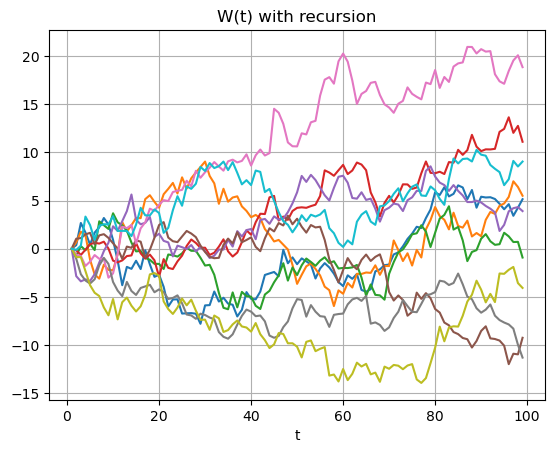

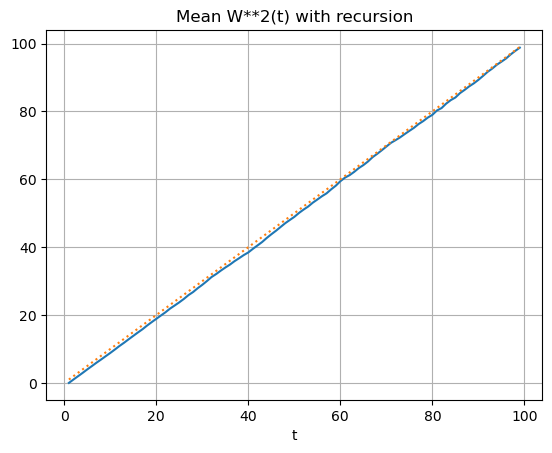

In [203]:
size = 1000
t_grid = np.arange(1, 100)
dim = 10

W = simulate_brownian_motion_from_brownian_bridge_rec(size, t_grid, dim, rng)

plt.plot(t_grid, W[0, :, :].T)
plt.grid()
plt.xlabel("t")
plt.title("W(t) with recursion")
plt.show()

plt.plot(t_grid, (W**2).mean(axis=0).mean(axis=0))
plt.plot(t_grid, t_grid, ":")
plt.grid()
plt.xlabel("t")
plt.title("Mean W**2(t) with recursion")
plt.show()

# Vectorized

In [260]:
def simulate_brownian_motion_from_brownian_bridge(
    size: int,
    t_grid: Union[float, NDArray[float_]],
    dim: int = 1,
    rng: np.random.Generator = None
) -> Union[float, NDArray[float_]]:
    """
    Simulates the trajectory of the standart d-dimensional Brownian motion using the Brownian bridge.

    Args:
        t_grid: time grid to simulate the price on.
        size: number of simulated trajectories.
        dim: dimensionality of the Brownian motion.
        rng: `np.random.Generator` used for simulation.

    Returns:
        np.ndarray of shape (size, len(t_grid)) with simulated trajectories if model dimension is 1.
        np.ndarray of shape (size, dim, len(t_grid)) with simulated trajectories if model dimension greater than 1.
    """
    if rng is None:
        rng = np.random.default_rng(seed=DEFAULT_SEED)

    if isinstance(t_grid, list):
        t_grid = np.array(t_grid)
    if not isinstance(t_grid, np.ndarray):
        t_grid = np.array([t_grid])
    dt = np.diff(np.concatenate([np.zeros(1), t_grid]))
    if np.any(dt < 0):
        raise ValueError("Time grid should be increasing.")

    if t_grid.shape[0] == 1:
        dW = rng.normal(size=(size, dim, len(t_grid)))
        if dim == 1:
            return np.cumsum(np.sqrt(dt) * dW, axis=2)[:, 0, :]    
        return np.cumsum(np.sqrt(dt) * dW, axis=2)

    W = np.zeros((size, dim, t_grid.shape[0]))
    W[:, :, -1] = np.sqrt(t_grid[-1]) * rng.normal(size=(size, dim))

    map = np.zeros(t_grid.shape[0])
    map[0] = 1
    map[-1] = 1

    while sum(map) != t_grid.shape[0]:
        idx_filled,  = np.where(map == 1)
        j = idx_filled[:-1]
        k = idx_filled[1:]
        idx_not_in_a_row = np.concatenate([np.diff(j), [2]]) != 1
        j = j[idx_not_in_a_row]
        k = k[idx_not_in_a_row]
        l = np.floor((j + k) / 2).astype(int)
        map[l] = 1
        
        N_step = rng.normal(size = (size, dim, l.shape[0]))
        E_step = ((t_grid[k] - t_grid[l]) / (t_grid[k] - t_grid[j]) * W[:, :, j] +
                (t_grid[l] - t_grid[j]) / (t_grid[k] - t_grid[j]) * W[:, :, k])
        std_step = ((t_grid[l] - t_grid[j]) *
                    (t_grid[k] - t_grid[l]) /
                    (t_grid[k] - t_grid[j]))
        W[:, :, l] = E_step + np.sqrt(std_step) * N_step
    if dim == 1:
        return W[:, 0, :]
    return W

In [261]:
W = simulate_brownian_motion_from_brownian_bridge(size=1, t_grid=10, dim=1, rng=rng)

In [262]:
W.shape

(1, 1)

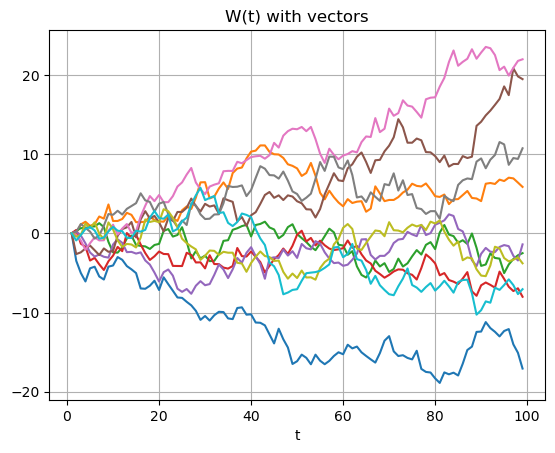

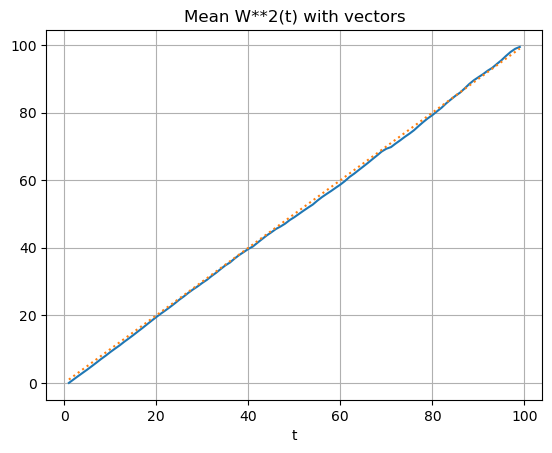

In [204]:
size = 1000
t_grid = np.arange(1, 100)
dim = 10

W = simulate_brownian_motion_from_brownian_bridge(size, t_grid, dim, rng)

plt.plot(t_grid, W[0, :, :].T)
plt.grid()
plt.xlabel("t")
plt.title("W(t) with vectors")
plt.show()

plt.plot(t_grid, (W**2).mean(axis=0).mean(axis=0))
plt.plot(t_grid, t_grid, ":")
plt.grid()
plt.xlabel("t")
plt.title("Mean W**2(t) with vectors")
plt.show()

# Compare speed

100%|██████████| 100/100 [00:00<00:00, 337.07it/s]


Median vestors:  0.0005739927291870117
Median recursion:  0.001757502555847168


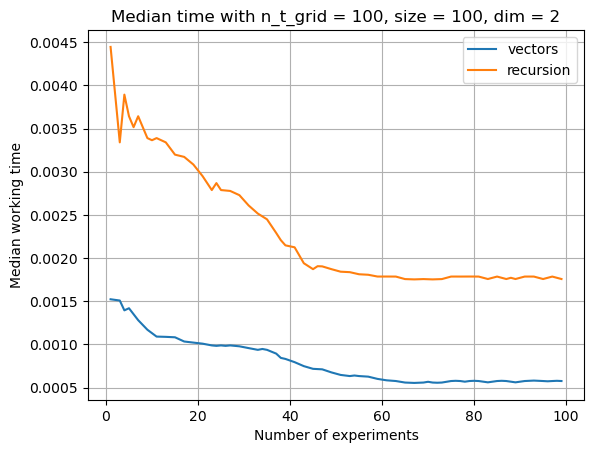

In [183]:
size = 10
t_grid = np.arange(1, 100)

# t_grid = np.concatenate([[-1000, -900, -100], t_grid]) + 1000

dim = 2

n = 100
t_recursion = np.zeros(n)
t_vectors = np.zeros(n)

median_recursion = np.zeros(n)
median_vectors = np.zeros(n)

for i in tqdm(range(n)):
    t0 = time()
    W = simulate_brownian_motion_from_brownian_bridge(size, t_grid, dim, rng)
    t_vectors[i]= time()-t0
    median_vectors[i] = np.median(t_vectors[:i])

    t0 = time()
    W = simulate_brownian_motion_from_brownian_bridge_rec(size, t_grid, dim, rng)
    t_recursion[i]= time()-t0
    median_recursion[i] = np.median(t_recursion[:i])

print("Median vestors: ", np.median(t_vectors))
print("Median recursion: ", np.median(t_recursion))

plt.plot(median_vectors, label="vectors")
plt.plot(median_recursion, label="recursion")
plt.grid()
plt.legend()
plt.title("Median time with n_t_grid = 100, size = 100, dim = 2")
plt.xlabel("Number of experiments")
plt.ylabel("Median working time")
plt.show()

# Working time from n_t_grid

100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


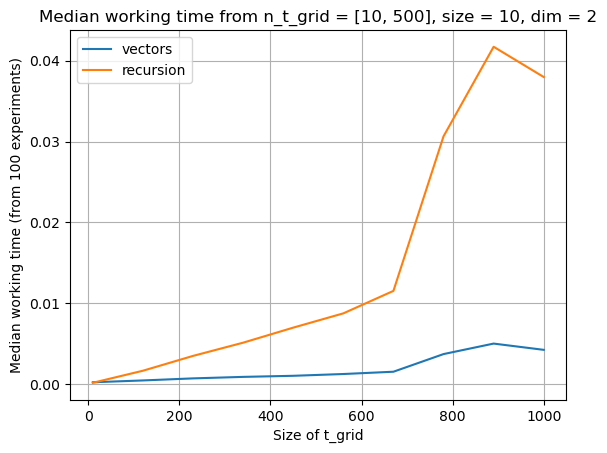

In [185]:
size = 10
dim = 2

n = 100
t_recursion = np.zeros(n)
t_vectors = np.zeros(n)

n_t_grid = np.linspace(10, 1000, 10).astype(int)

median_recursion = np.zeros(n_t_grid.shape[0])
median_vectors = np.zeros(n_t_grid.shape[0])

for j in tqdm(range(n_t_grid.shape[0])):
    t_grid = np.arange(0, n_t_grid[j])
    for i in range(n):
        t0 = time()
        W = simulate_brownian_motion_from_brownian_bridge(size, t_grid, dim, rng)
        t_vectors[i]= time()-t0
    

        t0 = time()
        W = simulate_brownian_motion_from_brownian_bridge_rec(size, t_grid, dim, rng)
        t_recursion[i]= time()-t0
    median_vectors[j] = np.median(t_vectors)
    median_recursion[j] = np.median(t_recursion)

plt.plot(n_t_grid, median_vectors, label="vectors")
plt.plot(n_t_grid, median_recursion, label="recursion")
plt.grid()
plt.legend()
plt.title("Median working time from n_t_grid = [10, 1000], size = 10, dim = 2")
plt.xlabel("Size of t_grid")
plt.ylabel("Median working time (from "+str(n)+" experiments)")
plt.show()

# Working time from size

100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


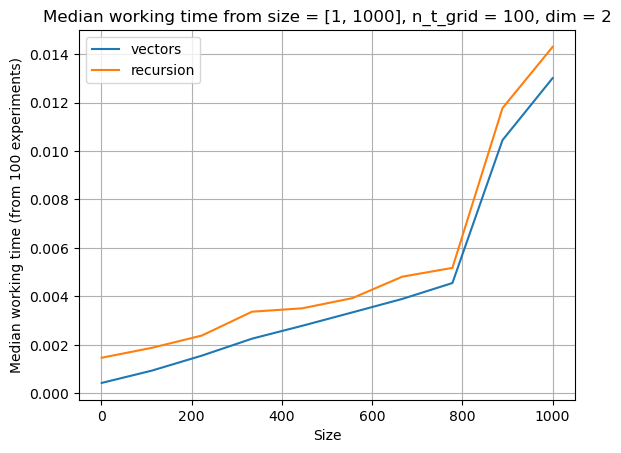

In [181]:
t_grid = np.arange(0, 100)
dim = 2

n = 100
t_recursion = np.zeros(n)
t_vectors = np.zeros(n)

size_array = np.linspace(1, 1000, 10).astype(int)


median_recursion = np.zeros(size_array.shape[0])
median_vectors = np.zeros(size_array.shape[0])

for j in tqdm(range(size_array.shape[0])):
    for i in range(n):
        t0 = time()
        W = simulate_brownian_motion_from_brownian_bridge(size_array[j], t_grid, dim, rng)
        t_vectors[i]= time()-t0
    

        t0 = time()
        W = simulate_brownian_motion_from_brownian_bridge_rec(size_array[j], t_grid, dim, rng)
        t_recursion[i]= time()-t0
    median_vectors[j] = np.median(t_vectors)
    median_recursion[j] = np.median(t_recursion)

plt.plot(size_array, median_vectors, label="vectors")
plt.plot(size_array, median_recursion, label="recursion")
plt.grid()
plt.legend()
plt.title("Median working time from size = [1, 1000], n_t_grid = 100, dim = 2")
plt.xlabel("Size")
plt.ylabel("Median working time (from "+str(n)+" experiments)")
plt.show()